# Prerequisites

In [2]:
!pip install simpletransformers
!pip install transformers[torch]

In [3]:
import pandas as pd
import torch
import numpy as np
import csv

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('CUDA is available! Running on GPU.')
else:
    device = torch.device('cpu')
    print('CUDA is not available. Running on CPU.')

# Set a random seed for reproducibility
SEED = 2137
torch.manual_seed(SEED)

# Clear any cached memory
torch.cuda.empty_cache()

# Check if CUDA is available
print('Is CUDA available?', torch.cuda.is_available())

CUDA is available! Running on GPU.
Is CUDA available? True


In [4]:
!nvidia-smi

Wed Mar 27 17:04:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


# Get the data

In [40]:
import zipfile
import os

use_google_drive = True

if use_google_drive:
  from google.colab import drive
  drive.mount('/content/drive')
  data = pd.read_csv("/content/drive/MyDrive/data_processed_balanced_125k.csv", header=0)

else:
  data = pd.read_csv("data_processed_balanced_125k.csv", header=0)

tokenizer_dir = "bert_save/tokenizer"
model_dir = "bert_save/model"

if use_google_drive:
  zip_file_path = "/content/drive/MyDrive/bert_save.zip"
else:
  zip_file_path = "bert_save.zip"

extract_dir = "bert_save"

# Create the extraction directory if it doesn't exist
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

data.head()

Mounted at /content/drive


,text,rating
0,We got tricked by the name Wyndham attached to...,0
1,"Very nice view indeed for this hotel, and pret...",0
2,We blocked out 10 rooms for a wedding and I ca...,0
3,I normally don't bother with reviews but this ...,0
4,stayed in this hotel last year at easter it wa...,0


# Since the data is organized, we need to shuffle it


In [41]:
data = data.sample(frac=1)
data.head()

,text,rating
1884,We checked into this hotel and were given a to...,0
64114,Ok for starters this is NOT a four star rating...,2
40293,"Like most Day inns, they are not much better t...",1
122786,"We stayed one night, and were very pleased wit...",4
68716,Pros: This has a great view of the lake. Bathr...,2


# Data actions

### Tokenize inputs

In [43]:
from transformers import BertTokenizer

MAX_LEN = 128

# Load BERT tokenizer
try:
  # Check if it's storred locally
  print("Trying to get the tokenizer from local files...")
  tokenizer = BertTokenizer.from_pretrained(tokenizer_dir)
  print(">>> Done!")
except:
  print("Tokenizer save not found, training a new one...")
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize input data
encodings = tokenizer(data['text'].tolist(), max_length=MAX_LEN, truncation=True, padding='max_length', return_tensors='pt')

# Convert ratings to tensor
labels = torch.tensor(data['rating'].tolist())

input_ids = encodings['input_ids'] # tokenized and encoded sentences
token_type_ids = encodings['token_type_ids'] # token type ids
attention_masks = encodings['attention_mask'] # attention masks

Trying to get the tokenizer from local files...
>>> Done!


### Split the data

In [44]:
from sklearn.model_selection import train_test_split

train_inputs, validation_inputs, train_labels, validation_labels, train_token_types, validation_token_types, train_masks, validation_masks = train_test_split(input_ids, labels, token_type_ids, attention_masks,
                                                            random_state=SEED, test_size=0.10, stratify = labels)

train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
train_token_types = torch.tensor(train_token_types)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)
validation_token_types = torch.tensor(validation_token_types)

<ipython-input-44-4a5d67c927e5>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs = torch.tensor(train_inputs)
<ipython-input-44-4a5d67c927e5>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(train_labels)
<ipython-input-44-4a5d67c927e5>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_masks = torch.tensor(train_masks)
<ipython-input-44-4a5d67c927e5>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires

### Prepare dataloaders

In [46]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

BATCH_SIZE = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels, train_token_types)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels, validation_token_types)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=BATCH_SIZE)


# Train the model

In [51]:
import torch
import torch.nn as nn
from transformers import BertForSequenceClassification, AdamW
from tqdm import tqdm
from matplotlib import pyplot as plt

LEARNING_RATE = 2e-5
NUM_EPOCHS = 1

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

try:
  model = BertForSequenceClassification.from_pretrained(model_dir).to(device)
except:
  model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5).to(device)  # 5 because ratings are from 0 to 4

  # Define optimizer and scheduler
  optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8)

  train_losses = []
  val_losses = []

  # Training loop
  for epoch in range(NUM_EPOCHS):
      # Training
      model.train()
      total_loss = 0
      progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch+1}', leave=False)
      for batch in progress_bar:
          b_input_ids, b_input_mask, b_labels, b_token_types = batch
          # Move tensors to GPU
          b_input_ids = b_input_ids.to(device)
          b_input_mask = b_input_mask.to(device)
          b_labels = b_labels.to(device)

          optimizer.zero_grad()
          outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
          loss = outputs.loss
          total_loss += loss.item()
          loss.backward()
          optimizer.step()
          progress_bar.set_postfix({'batch_loss': loss.item()})
      avg_train_loss = total_loss / len(train_dataloader)
      train_losses.append(avg_train_loss)

      # Validation
      model.eval()
      total_eval_loss = 0
      with torch.no_grad():
          for batch in validation_dataloader:
              b_input_ids, b_input_mask, b_labels, b_token_types = batch
              # Move tensors to GPU
              b_input_ids = b_input_ids.to(device)
              b_input_mask = b_input_mask.to(device)
              b_labels = b_labels.to(device)

              outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
              loss = outputs.loss
              total_eval_loss += loss.item()
      avg_val_loss = total_eval_loss / len(validation_dataloader)
      val_losses.append(avg_val_loss)

      print(f'Epoch {epoch+1}:')
      print(f'Training Loss: {avg_train_loss}')
      print(f'Validation Loss: {avg_val_loss}')


[]


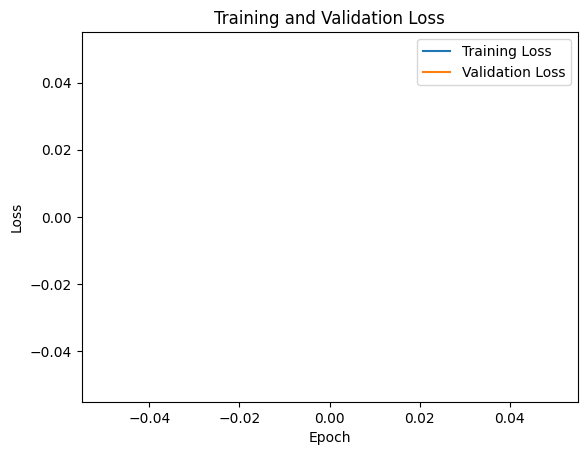

In [49]:
# Plot loss over time
print(train_losses)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Model tests

In [55]:
def predict_rating(review_text):
    # Tokenize input text
    inputs = tokenizer(review_text, return_tensors='pt', max_length=128, truncation=True, padding=True)

    # Move input tensors to the appropriate device
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Forward pass through the model
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the predicted class (rating)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()

    return predicted_class

# Example usage
custom_reviews = ["This hotel was great! Wonderful service and comfortable rooms.", "Not bad"]
for custom_review in custom_reviews:
  predicted_rating = predict_rating(custom_review)
  print(f"{custom_review}: >> {predicted_rating} <<")

This hotel was great! Wonderful service and comfortable rooms.: >> 4 <<
Not bad: >> 2 <<


# Evaluation

In [19]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


# Evaluation
model.eval()
all_predictions = []
all_labels = []
with torch.no_grad():
    for batch in validation_dataloader:
        b_input_ids, b_input_mask, b_labels, b_token_types = batch
        # Move tensors to GPU
        b_input_ids = b_input_ids.to(device)
        b_input_mask = b_input_mask.to(device)
        b_labels = b_labels.to(device)

        outputs = model(b_input_ids, attention_mask=b_input_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(b_labels.cpu().numpy())

# Compute metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')

# Classification report
print(classification_report(all_labels, all_predictions, digits=4))

Accuracy: 0.62144
Precision: 0.6203835416503629
Recall: 0.62144
F1-score: 0.6205420818531324
              precision    recall  f1-score   support

           0       0.69      0.68      0.69      2500
           1       0.50      0.51      0.51      2500
           2       0.58      0.58      0.58      2500
           3       0.60      0.56      0.58      2500
           4       0.73      0.78      0.76      2500

    accuracy                           0.62     12500
   macro avg       0.62      0.62      0.62     12500
weighted avg       0.62      0.62      0.62     12500



# Save model

In [33]:
# SAVE MODEL
import os
import re
import shutil
from datetime import datetime

dt_string = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")

output_dir = f"outputs/{dt_string}_{accuracy}ACC"

# Save the model and its configuration
model.save_pretrained(f"{output_dir}/model")

# Save the tokenizer as well
tokenizer.save_pretrained(f"{output_dir}/tokenizer")

('outputs/27-03-2024-18-10-44_0.62144ACC/tokenizer/tokenizer_config.json',
 'outputs/27-03-2024-18-10-44_0.62144ACC/tokenizer/special_tokens_map.json',
 'outputs/27-03-2024-18-10-44_0.62144ACC/tokenizer/vocab.txt',
 'outputs/27-03-2024-18-10-44_0.62144ACC/tokenizer/added_tokens.json')

# Download model

In [36]:
from google.colab import files

shutil.make_archive(output_dir, 'zip', output_dir)

# Download the zip file
files.download(output_dir + '.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>